In [1]:
from aggmap import loadmap, AggMapNet
from aggmap.aggmodel.xAI.perturb import GetGlobalIMP, GetLocalIMP
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import KFold
import tensorflow as tf

import warnings, os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
physical_gpus = tf.config.experimental.list_physical_devices('GPU') 
print("physical_gpus:")
print(physical_gpus)
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

physical_gpus:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-31 20:22:24.813062: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-12-31 20:22:24.911881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-12-31 20:22:24.911967: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-31 20:22:24.929253: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-12-31 20:22:24.929350: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-12-31 20:22:24.940298: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

In [4]:
func_grps = ['alkane', 'alkene', 'alkyne', 'aromatics', 'alkyl halides', 'alcohols', 'esters', 'ketones',\
 'aldehydes', 'carboxylic acids', 'ether', 'acyl halides', 'amines', 'amides', 'nitriles',\
 'nitro', '-N=C=O', '-N=C=S', 'ortho', 'meta', 'para']

In [5]:
dataset = './dataset/dataset_824p_all.csv'
data_df = pd.read_csv(dataset)
dfx = data_df[data_df.columns[1:-42]]
dfy = data_df[func_grps]
print('dfx\'s shape is {}'.format(dfx.shape))
print('dfy\'s shape is {}'.format(dfy.shape))

X = dfx.values
Y = dfy.values.astype(float)

dfx's shape is (8272, 824)
dfy's shape is (8272, 21)


In [6]:
channels = 10
mp = loadmap('./model/824p_IR_aggmap_correlation_c{}.mp'.format(channels))

In [7]:
# 匹配Fmap每个单元格的特征值
grid = mp.plot_grid()
df_grid = mp.df_grid.sort_values(['y', 'x']).reset_index(drop=True)
values = df_grid['v']

# 每个聚类的特征值
# features = mp.df_grid[mp.df_grid['Subtypes'] == 'cluster_10']['v'].values.astype('float')
# print(features.shape)
# features = np.sort(features)
# print(features[-300:])

2022-12-31 20:22:41,155 - INFO - [bidd-aggmap] - generate file: ./feature points_824_correlation_umap_mp
2022-12-31 20:22:41,194 - INFO - [bidd-aggmap] - save html file to ./feature points_824_correlation_umap_mp


In [ ]:
# 训练生成模型model

for random_seed in [128]:   # 随机种子用于划分数据集
    outer = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold_idx = 0
    
    for train_idx, test_idx in outer.split(X): # 五折交叉
        train_X, test_X = X[train_idx], X[test_idx]
        trainY, testY = Y[train_idx], Y[test_idx]
        
        trainX = mp.batch_transform(train_X, scale_method='standard')
        testX = mp.batch_transform(test_X, scale_method='standard')
        print("trainX shape is: " + str(trainX.shape))
        print("trainY shape is: " + str(trainY.shape))

        model_path = './model/824p_model_IR_MultiLabel_c{}_fold{}.h5'.format(channels, fold_idx)
        
        clf = AggMapNet.MultiLabelEstimator(epochs=50, conv1_kernel_size=3, batch_size=4, gpuid=0, verbose=0)
        clf.fit(trainX, trainY)
        
        clf._model.save(model_path)
        
        fold_idx += 1

In [ ]:
# 模型解释

all_importance = {}

for random_seed in [128]:   # 随机种子用于划分数据集
    outer = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold_idx = 0
    
    for train_idx, test_idx in outer.split(X): # 五折交叉
        train_X, test_X = X[train_idx], X[test_idx]
        trainY, testY = Y[train_idx], Y[test_idx]
        
        trainX = mp.batch_transform(train_X, scale_method='standard')
        # testX = mp.batch_transform(test_X, scale_method='standard')
        print("trainX shape is: " + str(trainX.shape))
        print("trainY shape is: " + str(trainY.shape))

        model_path = './model/824p_IR_MultiLabel_c{}_fold1_seed128.h5'.format(channels)
        model = load_model(model_path, custom_objects={'sigmoid_cross_entropy_with_logits_v2': tf.nn.sigmoid_cross_entropy_with_logits})
        
        dfY = pd.DataFrame(trainY, columns=func_grps)

        df_imp = GetGlobalIMP(model, mp, trainX, dfY, task_type='classification', apply_logrithm=True, sigmoidy=False)
        all_importance.update({fold_idx: df_imp})

        fold_idx += 1
        break

In [ ]:
all_importance[0].columns.tolist()

In [ ]:
all_importance[0]['alkane_importance']

In [ ]:
# 保存importance到csv

impor_path = './importance/1647_IR_global_importance_5fold_seed128.csv'
points = [i for i in range(len(all_importance[0]['alkane_importance']))]     # 横坐标数据范围
df_impor = pd.DataFrame(columns=['fold', 'func_grps'] + points)
i = 0

for k, v in all_importance.items():

    for grp in func_grps:
        func_row = [k, grp]

        func_impor_col = '{}_importance'.format(grp)
        func_impor = v[func_impor_col]
        
        for p in points:
            func_row.append(func_impor[p])
        
        df_impor.loc[i] = func_row
        i += 1

df_impor.to_csv(impor_path, index=False)


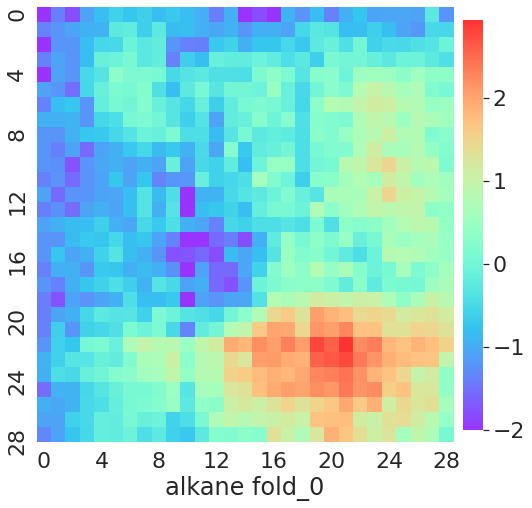

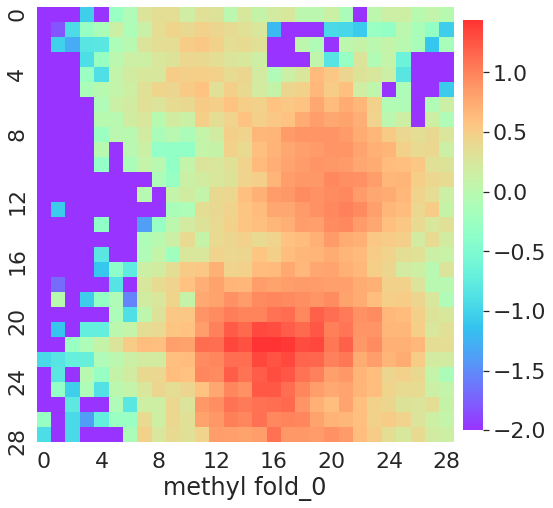

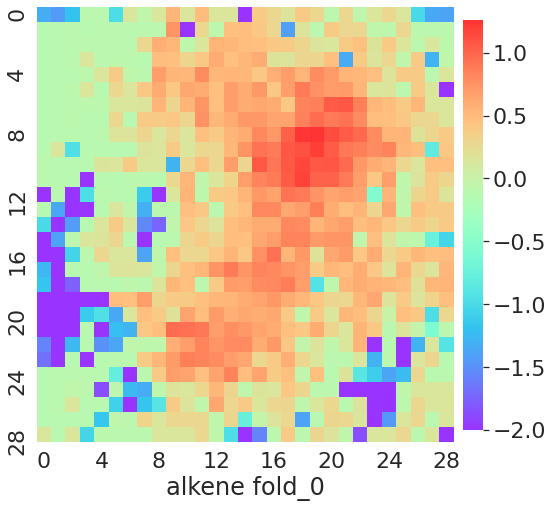

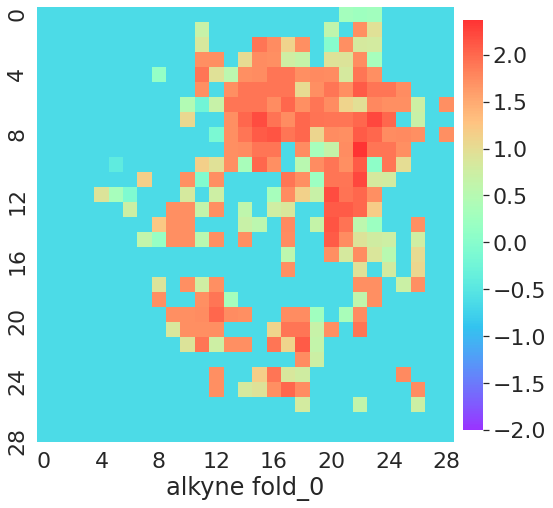

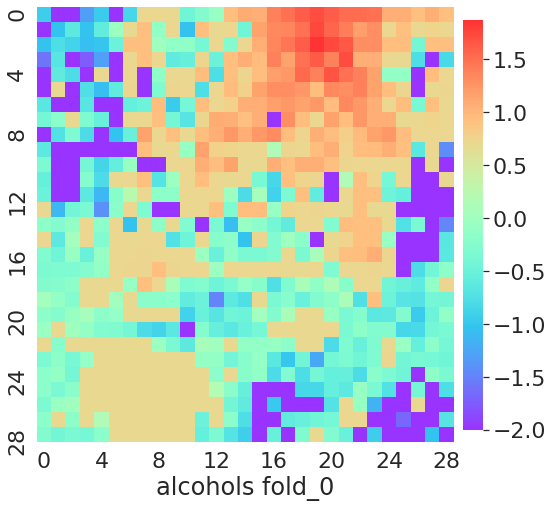

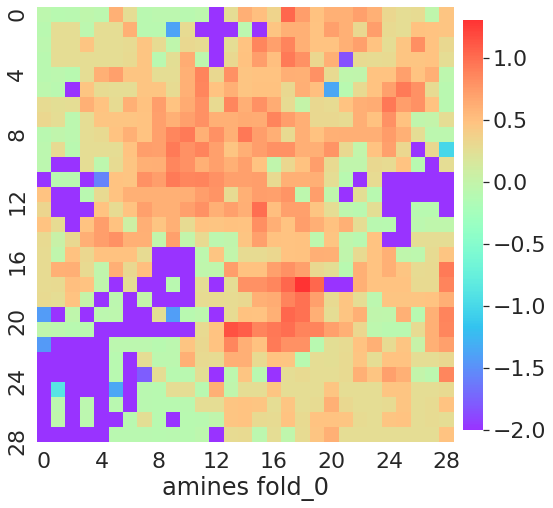

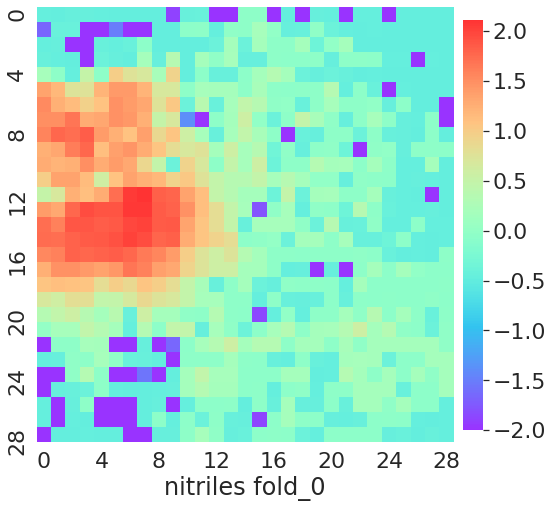

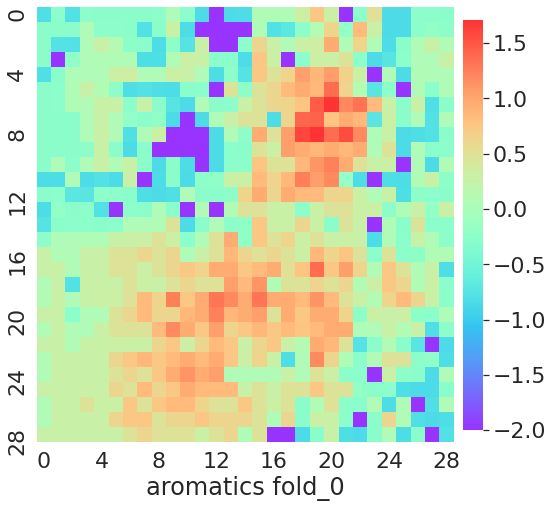

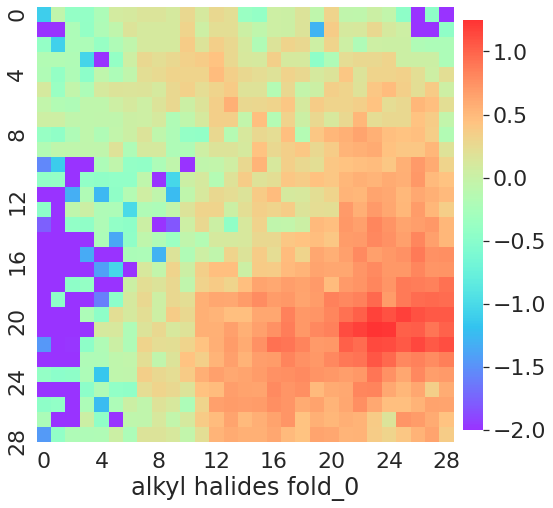

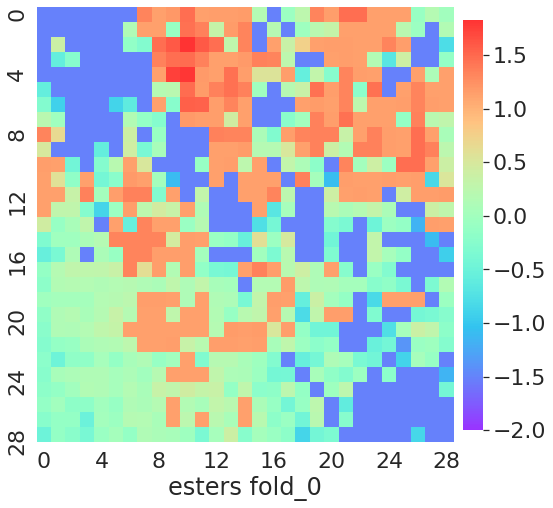

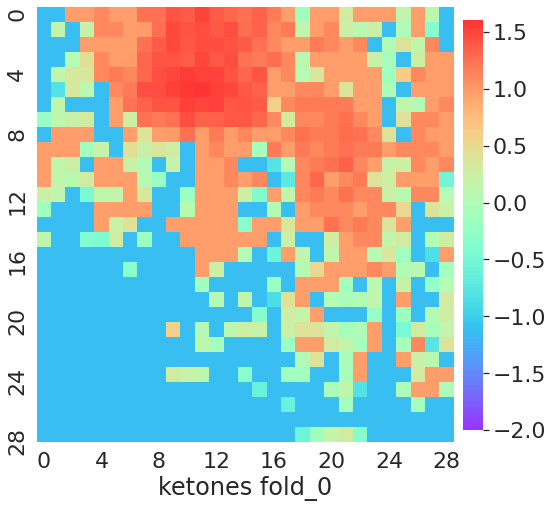

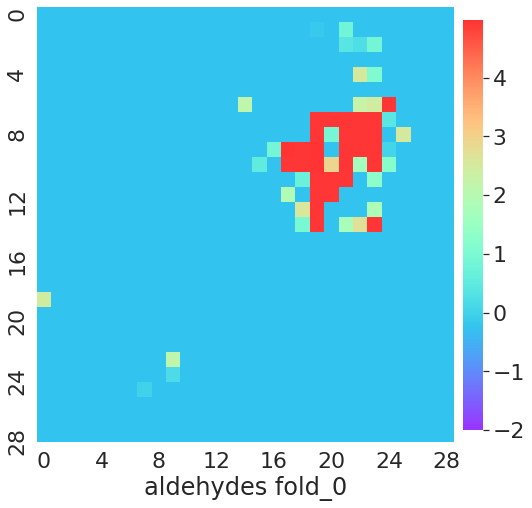

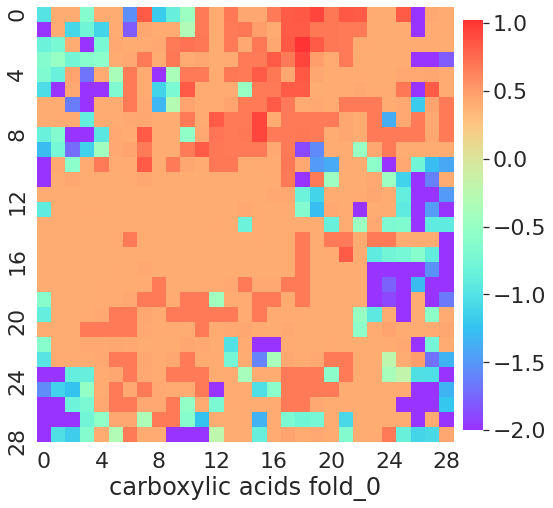

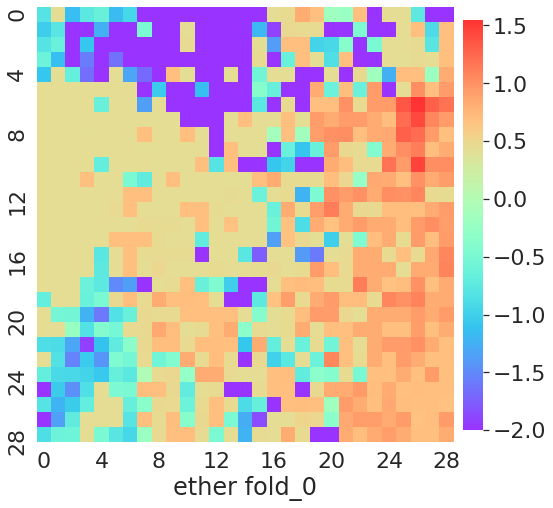

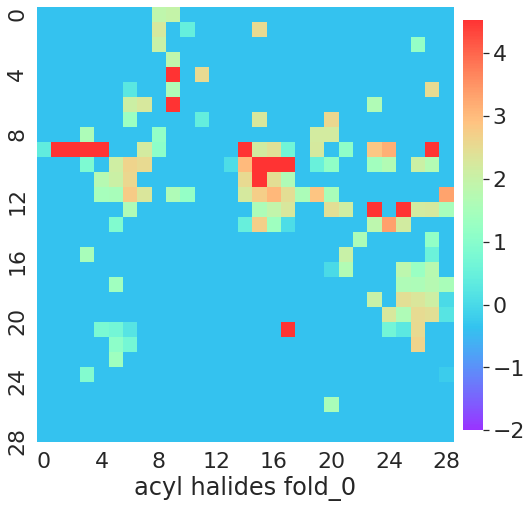

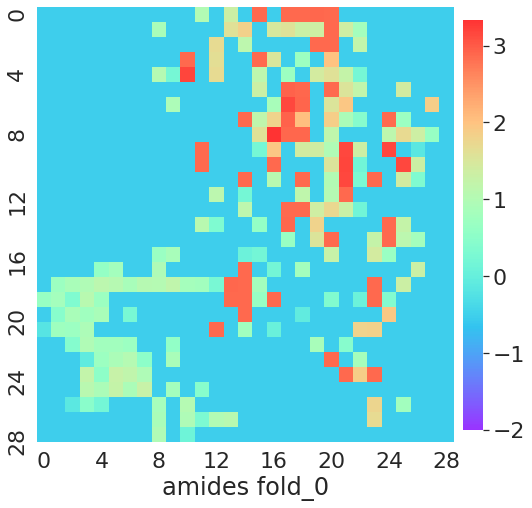

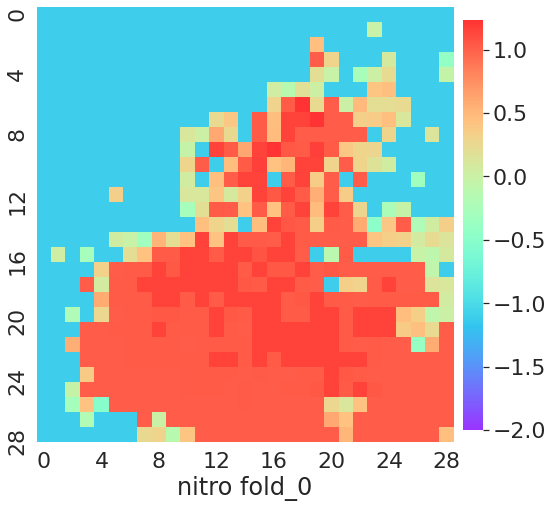

In [8]:
# 画出importance的热图

impor_path = './importance/824p_IR_global_importance_5fold_seed128.csv'
importance = pd.read_csv(impor_path)

func_grp_amount = 17

for f in range(func_grp_amount):
    sns.set(style='white', font='sans-serif', font_scale=2)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    fold_id = 0

    for ax in [axes]:
        func_grp_id = fold_id * func_grp_amount + f

        IMPM = importance.loc[func_grp_id].values[2:].reshape(*mp.fmap_shape)
        sns.heatmap(IMPM.astype(float), 
                    cmap='rainbow', alpha=0.8, xticklabels=4, ax=ax, 
                    yticklabels=4, vmin=-2, 
                    cbar_kws={'fraction':0.046, 'pad':0.02})

        func_grp = importance.loc[func_grp_id]['func_grps']
        ax.set_xlabel('{} fold_{}'.format(func_grp, fold_id))
        fold_id += 1

    #bottom, top = ax.get_ylim()
    plt.subplots_adjust(wspace=0.5)

    plt.savefig('./importance/824p_IR_importance_{}.png'.format(func_grp), dpi = 400, bbox_inches="tight")

In [ ]:
# 找最重要的特征值 top 10

impor_path = './importance/824p_IR_global_importance_5fold_seed128.csv'
importance = pd.read_csv(impor_path)
func_grp = importance['func_grps'].values
importance = importance[importance.columns[2:]]

top10_im = []
importance_T = pd.DataFrame(importance.values.T, index=values, columns=func_grp)
for grp in func_grp:
    print(grp)
    top_im = np.array(importance_T.nlargest(10, columns=[grp]).index)
    print(top_im)
    top10_im.append(top_im)
    
top10_array = np.concatenate([[func_grp], np.array(top10_im).T], axis=0).T
top10_df = pd.DataFrame(top10_array, columns=['func_grp', 'top1', 'top2', 'top3', 'top4', 'top5', 'top6', 'top7', 'top8', 'top9', 'top10'])
top10_df.to_csv('./importance/824p_IR_global_importance_top10.csv', index=False)